# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

## Izhikevich Spiking network model in NEST

For every neuron $i$ in region node $n$ modelled in ANNarchy as a spiking network:

Membrane potential:

$ \dot{V}_m = n_2V_m^2 + n_1V_m + n_0140 - U_m/C $

$\;\;\;\;\;\;\;- g_{AMPA}(V_m-E_{AMPA}) - g_{GABA}(V_m-E_{GABA}) - g_{BASE}V_m + I_e $

where the conductances follow the equations:

$ \dot{g}_{AMPA} = - g_{AMPA} / \tau_{AMPA} + \left[\sum_k \delta(t-t_k) \right]_{Exc}$

$ \dot{g}_{GABA} = - g_{GABA} / \tau_{GABA} + \left[\sum_k \delta(t-t_k) \right]_{Inh}$

$ \dot{g}_{BASE} = - g_{BASE} / \tau_{BASE} + \left[\sum_k \delta(t-t_k) \right]_{BASE}$

and recovery variable:

$ \dot{U}_m = a(bV_m - U_m)$


When $ V_m > V_{th} $ , $ V_m $ is set to $ c $, and $ U_m $ is incremented by $ d $.

# WORKFLOW:

In [1]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *

work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_nest")[0], "data")
outputs_path = os.path.join(work_path, "outputs/Izhikevich")
sim_mode_path = os.path.join(outputs_path, "SpikingCortex")
config = Config(output_base=sim_mode_path)

config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

2021-02-26 11:14:36,566 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-02-26 11:14:36,566 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-02-26 11:14:36,569 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-02-26 11:14:36,569 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-02-26 11:14:36,572 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-02-26 11:14:36,572 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-02-26 11:14:36,576 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-02-26 11:14:36,576 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-02-26 11:14:36,579 - INFO - tvb_multiscale.tv

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

Region labels:
['GPe_Left' 'GPi_Left' 'STN_Left' 'Striatum_Left' 'Thal_Left' 'Cortex']


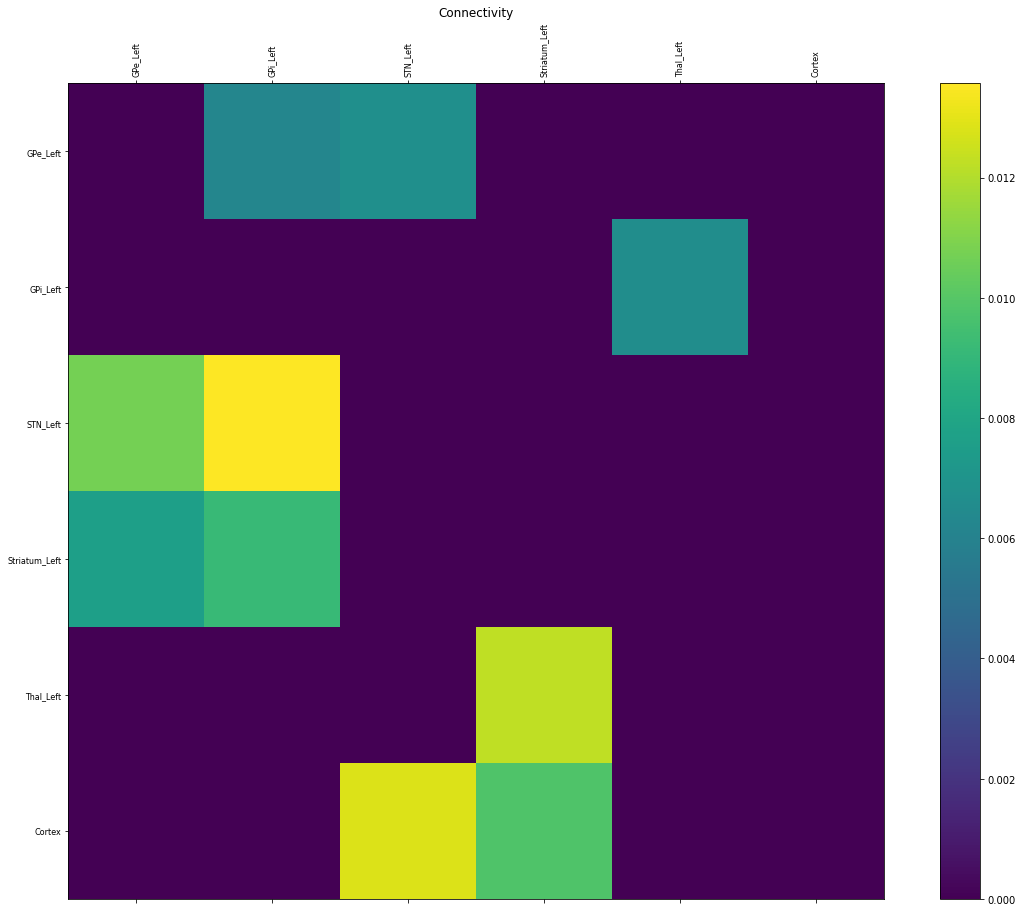

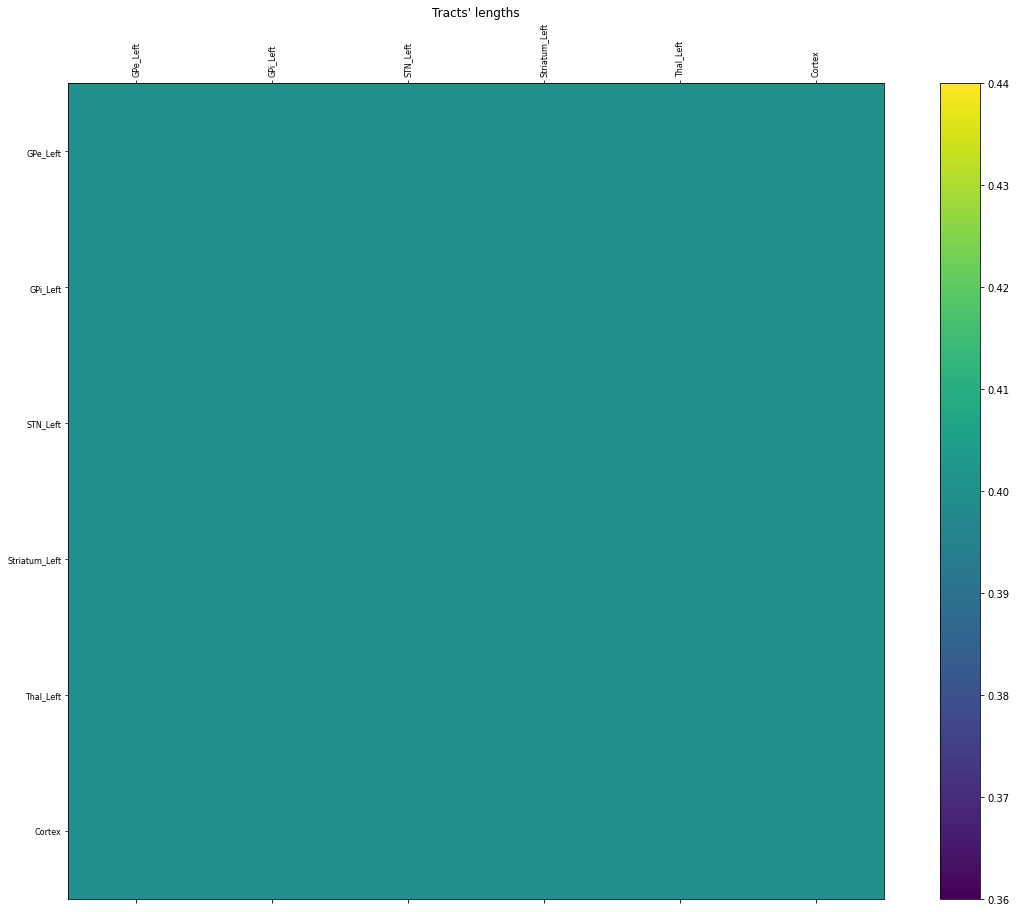

In [2]:
from tvb.simulator.models.reduced_wong_wang_exc_io import ReducedWongWangExcIO

# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the simulator by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------

from tvb.datatypes.connectivity import Connectivity
from tvb.simulator.cosimulator import CoSimulator
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG
    

conn_path = os.path.join(data_path, "basal_ganglia_conn_incl_cortex")

w=np.loadtxt(os.path.join(conn_path, "opti_CON1_lh_weights_incl_cortex.txt"))
c=np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers_incl_cortex.txt"), usecols=range(1,3))
rl= np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers_incl_cortex.txt"), dtype="str", usecols=(0,))
t= np.loadtxt(os.path.join(conn_path, "BGplusAAL_tract_lengths_incl_cortex.txt"))

# Keep only the BG and a single Cortex node:
c = c[:11]
rl = rl[:11]
rl[10] = "Cortex"
w = w[:11][:, :11]
t = t[:11][:, :11]

# Keep only left hemisphere and the Cortex:
inds = np.arange(0,10,2).astype("i").tolist() + [10]
c = c[inds] 
rl = rl[inds]
print("Region labels:\n%s" % rl)
# 0. GPe_Left, 1. GPi_Left, 2. STN_Left, 3. Striatum_Left, 4. Thal_Left, 5. Cortex
w = w[inds][:, inds]
t = t[inds][:, inds]

# % loadedParams ={
# %     	'D1GPi_probs': probs[0],
# %     	'D1GPi_weights'  : weights[0],
# %     	'D2GPe_probs'   : probs[1],
# %     	'D2GPe_weights'  : weights[1],
# %     	'GPeSTN_probs'   : probs[2],
# %     	'GPeSTN_weights'  : weights[2],
# %     	'STNGPe_probs'   : probs[3],
# %     	'STNGPe_weights'  : weights[3],
# %     	'STNGPi_probs'   : probs[4],
# %     	'STNGPi_weights' : weights[4],
# %     	'GPeGPi_probs'   : probs[5],
# %     	'GPeGPi_weights'  : weights[5],
# %     	'GPeGPe_probs'   : probs[6],
# %     	'GPeGPe_weights'  : weights[6],
# %     	'GPiGPi_probs'   : probs[7],
# %     	'GPiGPi_weights'  : weights[7],
# %     	'GPiThal_probs'   : probs[8],
# %     	'GPiThal_weights'  : weights[8],
# %     	'ThaliSN_probs'   : probs[9],
# %     	'ThaliSN_weights'  : weights[9],
# %     	'ThaldSN_probs'   : probs[10],
# %     	'ThaldSN_weights'  : weights[10],
# %     	'dSNdSN_probs'   : probs[11],
# %     	'dSNdSN_weights'  : weights[11],
# %     	'iSNiSN_probs'   : probs[12],
# %     	'iSNiSN_weights'  : weights[12],
# %     	'CdSN_probs'   : probs[13],
# %     	'CdSN_weights'  : weights[13],
# %     	'CiSN_probs'   : probs[14],
# %     	'CiSN_weights'  : weights[14],
# %     	'CSTN_probs'   : probs[15],
# %     	'CSTN_weights'  : weights[15],
# %     	'V1Inh_probs'    : probs[16],
# %     	'V1Inh_weights'  : weights[16],
# %     	'InhV1_probs'    : probs[17],
# %     	'InhV1_weights'  : weights[17],
# %     	'InhInh_probs'   : probs[18],
# %     	'InhInh_weights'  : weights[18]}

# 0. GPe_Left, 1. GPi_Left, 2. STN_Left, 3. Striatum_Left, 4. Thal_Left
BG_opt_matrix_weights = np.zeros((5, 5))

conn_mode = "patient"
if conn_mode == "average":
    weights_maith = np.array([1.93, 3.56, 1.46, 4.51, 3.52, 2.30, 2.34, 3.78, 1.98, 
                             1.30, 1.82, 3.56, 3.02, 1.78, 1.36, 2.27, 4.13, 2.74, 3.27])*1e-3  # controls
#     weights_maith = np.array([3.27, 3.80, 2.65, 3.66, 3.06, 3.06, 3.25, 4.02, 3.32, 
#                             2.98, 3.45, 3.64, 2.50, 2.12, 2.86, 2.79, 3.96, 3.69, 3.87])*1e-3   # patients
    # probs_maith = ????
else:
    import scipy.io as sio
    conn_path = os.path.join(data_path, "basal_ganglia_conn_incl_cortex")
    weights = sio.loadmat(os.path.join(conn_path,"OutputSim_Patient01.mat")) # weights start from index 19
    weights_maith = weights["X"][0, 19:] # these are indices 19 till 37
    probs_maith = weights["X"][0, :19] # these are indices 0 till 18

wdSNGPi = BG_opt_matrix_weights[3, 1] = weights_maith[0]
wiSNGPe = BG_opt_matrix_weights[3, 0] = weights_maith[1]
wGPeSTN = BG_opt_matrix_weights[0, 2] = weights_maith[2]
wSTNGPe = BG_opt_matrix_weights[2, 0] = weights_maith[3]
wSTNGPi = BG_opt_matrix_weights[2, 1] = weights_maith[4]
wGPeGPi = BG_opt_matrix_weights[0, 1] = weights_maith[5]  
wGPiTh = BG_opt_matrix_weights[1, 4] = weights_maith[8]
wThdSN = BG_opt_matrix_weights[4, 3] = weights_maith[10] # Th -> dSN
    
sliceBGnet = slice(0,5)
w[sliceBGnet, sliceBGnet] = BG_opt_matrix_weights

wGPeGPe = weights_maith[6]   # "GPe" -> "GPe" 
wGPiGPi = weights_maith[7]   # "GPi" -> "GPi" 
wThiSN = weights_maith[9]    # "Eth" -> "IiSN" 

wdSNdSN = weights_maith[11]  # "IdSN" -> "IdSN" 
wiSNiSN = weights_maith[12]  # "IiSN" -> "IiSN" 
wCtxdSN = w[5, 3] = weights_maith[13]  # "CxE" -> "IdSN" 
wCtxiSN = weights_maith[14] # "CxE" -> "IiSN" 
wCtxSTN = w[5, 2] = weights_maith[15]  # "CxE" -> "Estn"
wCtxEtoI = weights_maith[16] # "CxE" -> "CxI"
wCtxItoE = weights_maith[17] # "CxI" -> "CxE"
wCtxItoI = weights_maith[18] # "CxI" -> "CxI"

pdSNGPi = probs_maith[0]
piSNGPe = probs_maith[1]
pGPeSTN = probs_maith[2]
pSTNGPe = probs_maith[3]
pSTNGPi = probs_maith[4]
pGPeGPi = probs_maith[5]  
pGPeGPe = probs_maith[6]  # "GPe" -> "GPe" 
pGPiGPi = probs_maith[7]  # "GPi" -> "GPi" 
pGPiTh = probs_maith[8]
pThiSN =  probs_maith[9]  # "Eth" -> "IiSN
pThdSN = probs_maith[10] # Th --> dSN
pdSNdSN = probs_maith[11] # "IdSN" -> "IdSN" 
piSNiSN = probs_maith[12] # "IiSN" -> "IiSN" 
pCtxdSN = probs_maith[13]  # "CxE" -> "IdSN" 
pCtxiSN = probs_maith[14] # "CxE" -> "IiSN" 
pCtxSTN = probs_maith[15]  # "CxE" -> "Estn"
pCtxEtoI = probs_maith[16] # "CxE" -> "CxI"
pCtxItoE = probs_maith[17] # "CxI" -> "CxE"
pCtxItoI = probs_maith[18] # "CxI" -> "CxI"
    

# Finally form the TVB Connectivity
dt = 0.1
speed = 4.0
delays = False
if not delays:
    t = dt * speed * np.ones(t.shape)
connectivity=Connectivity(region_labels=rl, weights=w, centres=c, tract_lengths=t)

# Normalize connectivity weights
# connectivity.weights = connectivity.scaled_weights(mode="region")
# connectivity.weights /= np.percentile(connectivity.weights, 99)
# connectivity.weights[connectivity.weights > 1.0] = 1.0
connectivity.speed = np.array([speed])
connectivity.configure()

#white_matter_coupling = coupling.Linear(a=0.014)
# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = CoSimulator()
#simulator.use_numba = False
model_params = {}
simulator.model = ReducedWongWangExcIO(**model_params)

simulator.connectivity = connectivity

simulator.integrator = HeunStochastic()
simulator.integrator.dt = dt
simulator.integrator.noise.nsig = np.array([0.001])

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

plotter.plot_tvb_connectivity(simulator.connectivity);

## 2. Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [3]:
from tvb_multiscale.tvb_nest.nest_models.builders.models.basal_ganglia_izhikevich import BasalGangliaIzhikevichBuilder

# Select the regions for the fine scale modeling with NEST spiking networks
number_of_regions = simulator.connectivity.region_labels.shape[0]
#including cortex node:
nest_nodes_ids = [0, 1, 2, 3, 4, 5]  # the indices of fine scale regions modeled with NEST

# Build a NEST network model with the corresponding builder
nest_model_builder = BasalGangliaIzhikevichBuilder(simulator, nest_nodes_ids, config=config)



# Using all default parameters for this example


# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
from copy import deepcopy

population_neuron_model = "izhikevich_hamker"

nest_model_builder.population_order = 200 # reduce for speed

# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

nest_model_builder.params_common = \
    {"V_m": -70.0, "U_m": -18.55, "E_rev_AMPA": 0.0, "E_rev_GABA_A": -90.0, "V_th": 30.0, "V_r": 0.0, "c": -65.0,
     "C_m": 1.0, "I_e": 0.0, 
     "current_stimulus_scale": -200.0, "current_stimulus_mode": 2,
     "tau_rise": 1.0, "tau_rise_AMPA": 10.0, "tau_rise_GABA_A": 10.0,
     "n0": 140.0, "n1": 5.0, "n2": 0.04}

nest_model_builder._paramsI = deepcopy(nest_model_builder.params_common)
nest_model_builder._paramsI.update({"a": 0.005, "b": 0.585, "d": 4.0})
nest_model_builder._paramsE = deepcopy(nest_model_builder.params_common)
nest_model_builder.paramsStr = deepcopy(nest_model_builder.params_common)
nest_model_builder.paramsStr.update({"V_th": 40.0, "C_m": 50.0, "V_r": -80.0,
                                     "n0": 61.65119, "n1": 2.594639, "n2": 0.022799, 
                                     "a": 0.05, "b": -20.0, "c": -55.0, "d": 377.0})

nest_model_builder.Igpe_nodes_ids = [0]
nest_model_builder.Igpi_nodes_ids = [1]
nest_model_builder.Estn_nodes_ids = [2]
nest_model_builder.Eth_nodes_ids = [4]
nest_model_builder.Istr_nodes_ids = [3]
#including cortex node:
nest_model_builder.Crtx_nodes_ids = [5]

I_nodes_ids = nest_model_builder.Igpe_nodes_ids + nest_model_builder.Igpi_nodes_ids + nest_model_builder.Crtx_nodes_ids
E_nodes_ids = nest_model_builder.Estn_nodes_ids + nest_model_builder.Eth_nodes_ids + nest_model_builder.Crtx_nodes_ids


def paramsE_fun(node_id):
    paramsE = deepcopy(nest_model_builder._paramsE)
    if node_id in nest_model_builder.Estn_nodes_ids:
        paramsE.update({"a": 0.005, "b": 0.265, "d": 2.0, "I_e": 3.0})  # dictionary of params for Estn
    elif node_id in nest_model_builder.Eth_nodes_ids:
        paramsE.update({"a": 0.02, "b": 0.25, "d": 0.05, "I_e": 3.5}) # dictionary of params for Eth
    elif node_id in nest_model_builder.Crtx_nodes_ids:
        paramsE.update({"V_m": -72.0, "U_m": -14.0, "a": 0.02, "b": 0.2, "d": 6.0,"c": -72.0, "I_e": 7.0}) # 50.0 dictionary of params for CortexExcitatory
    return paramsE
    
def paramsI_fun(node_id):
    # For the moment they are identical, unless you differentiate the noise parameters
    paramsI = deepcopy(nest_model_builder._paramsI)
    if node_id in nest_model_builder.Igpe_nodes_ids:
        paramsI.update({"I_e": 12.0})  # 12.0
    elif node_id in nest_model_builder.Igpi_nodes_ids:
        paramsI.update({"I_e": 30.0})  # 30.0
    elif node_id in nest_model_builder.Crtx_nodes_ids:
        paramsI.update({"V_m": -72.0, "U_m": -14.0, "c": -72.0,"a": 0.02, "b": 0.2, "d": 6.0, "I_e": 0.0})
    return paramsI
    
# Populations' configurations
# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property
nest_model_builder.populations = [
    {"label": "E", "model": population_neuron_model,  
     "params":  paramsE_fun, 
     "nodes": E_nodes_ids,  # Estn in [2], Eth in [4], Cortex in [5]
     "scale": lambda node_id: 3.0 if node_id in nest_model_builder.Crtx_nodes_ids else 1.0},
    {"label": "I", "model": population_neuron_model,  
     "params": paramsI_fun, 
     "nodes": I_nodes_ids,  # Igpe in [0], Igpi in [1], Cortex in [5]
     "scale": lambda node_id: 0.75 if node_id in nest_model_builder.Crtx_nodes_ids else 1.0},
    {"label": "IdSN", "model": population_neuron_model,   
     "params": nest_model_builder.paramsStr, 
     "nodes": nest_model_builder.Istr_nodes_ids,  # IdSN in [3]
     "scale": 1.0},
    {"label": "IiSN", "model": population_neuron_model,   # IiSN in [3]
     "params": nest_model_builder.paramsStr, 
     "nodes": nest_model_builder.Istr_nodes_ids,  # None means "all"
     "scale": 1.0}
]

# Within region-node connections
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

synapse_model = "static_synapse"
conn_spec = {"allow_autapses": True, "allow_multapses": True, 'rule': "all_to_all",
             "indegree": None, "outdegree": None, "N": None, "p": 0.1}
conn_spec_bernoulli = conn_spec.copy()
conn_spec_bernoulli.update({'rule': "pairwise_bernoulli", "p": 0.5})

def conn_spec_prob(p):
    output = conn_spec_bernoulli.copy()
    output["p"] = p
    return output
    
within_node_delay = 1.0

# for each connection, we have a different probability
nest_model_builder.populations_connections = [
# #      #        source   ->   target
    {"source": "I", "target": "I",  # I -> I This is a self-connection for "CxI"
     "model": synapse_model, "conn_spec": conn_spec_prob(pCtxItoI),  # conn_spec
     "weight": -np.abs(wCtxItoI), "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Crtx_nodes_ids,
    },  # None means apply to all
    {"source": "I", "target": "I",  # I -> I This is a self-connection for populations "Igpe"
     "model": synapse_model, "conn_spec": conn_spec_prob(pGPeGPe),  # conn_spec
     "weight": -np.abs(wGPeGPe), "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Igpe_nodes_ids,
    },  # None means apply to all
    {"source": "I", "target": "I",  # I -> I This is a self-connection for populations "Igpi"
     "model": synapse_model, "conn_spec": conn_spec_prob(pGPiGPi),  # conn_spec
     "weight": -np.abs(wGPiGPi), "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Igpi_nodes_ids,
    },  # None means apply to all
    {"source": "IdSN", "target": "IdSN",  # IdSN -> IdSN This is a self-connection for population "IdSN"
     "model": synapse_model, "conn_spec": conn_spec_prob(pdSNdSN),  # conn_spec
     "weight": -np.abs(wdSNdSN), "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Istr_nodes_ids},
    {"source": "IiSN", "target": "IiSN",  # IiSN -> IiSN This is a self-connection for population "IiSN"
     "model": synapse_model, "conn_spec": conn_spec_prob(piSNiSN),  # conn_spec
     "weight": -np.abs(wiSNiSN), "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Istr_nodes_ids},
    {"source": "E", "target": "I",          # "CxE" -> "CxI" #
     "model": synapse_model, "conn_spec": conn_spec_prob(pCtxEtoI),  # conn_spec
     "weight": np.abs(wCtxEtoI), "delay": within_node_delay,  
     "receptor_type": 0, "nodes": nest_model_builder.Crtx_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",          # "CxI" -> "CxE" 
     "model": synapse_model, "conn_spec": conn_spec_prob(pCtxItoE),  # conn_spec
     "weight": -np.abs(wCtxItoE), "delay": within_node_delay,  
     "receptor_type": 0, "nodes": nest_model_builder.Crtx_nodes_ids}  # None means apply to all   
    ]



# Among/Between region-node connections
# Given that only the AMPA population of one region-node couples to
# all populations of another region-node,
# we need only one connection type
        
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# depends on regions, set a handle to a function with
# arguments (source_region_index=None, target_region_index=None)

from tvb_multiscale.core.spiking_models.builders.templates import scale_tvb_weight, tvb_delay

# NOTE!!! TAKE CARE OF DEFAULT simulator.coupling.a!
nest_model_builder.global_coupling_scaling = 1.0 # nest_model_builder.coupling_a 
# if we use Reduced Wong Wang model, we also need to multiply with the global coupling constant G:
# nest_model_builder.global_coupling_scaling *= nest_model_builder.G
        
class TVBWeightFun(object):
    tvb_weights = nest_model_builder.tvb_weights
    global_coupling_scaling = nest_model_builder.global_coupling_scaling
    sign = 1

    def __init__(self, sign=1):
        self.sign = sign
        self.global_coupling_scaling *= self.sign
        
    def __call__(self, source_node, target_node):
        return scale_tvb_weight(source_node, target_node, self.tvb_weights,
                                scale=self.global_coupling_scaling)
    
tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(nest_model_builder.tvb_dt, tvb_delay(source_node, target_node, nest_model_builder.tvb_delays))

# Total excitatory spikes of one region node will be distributed to
nest_model_builder.nodes_connections = [
#     #        source    ->     target
    {"source": "IdSN", "target": "I",             # "IdSN" -> "Igpi"
     "model": synapse_model, "conn_spec": conn_spec_prob(pdSNGPi),  # conn_spec
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Istr_nodes_ids, 
     "target_nodes": nest_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "IiSN", "target": "I",            # "IiSN" -> "Igpe"
     "model": synapse_model, "conn_spec": conn_spec_prob(piSNGPe),  # conn_spec
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Istr_nodes_ids, 
     "target_nodes": nest_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",             # "Igpe" -> "Igpi"
     "model": synapse_model, "conn_spec": conn_spec_prob(pGPeGPi),  # conn_spec
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpe_nodes_ids, 
     "target_nodes": nest_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",              # "Igpi" -> "Eth"
     "model": synapse_model, "conn_spec": conn_spec_prob(pGPiTh),  # conn_spec
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpi_nodes_ids, 
     "target_nodes": nest_model_builder.Eth_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",             # "Igpe" -> "Estn"
     "model": synapse_model, "conn_spec": conn_spec_prob(pGPeSTN),  # conn_spec
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpe_nodes_ids, 
     "target_nodes": nest_model_builder.Estn_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IdSN",   # "Eth" -> ["IdSN"] 
     "model": synapse_model, "conn_spec": conn_spec_prob(pThdSN),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Eth_nodes_ids, 
     "target_nodes": nest_model_builder.Istr_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IiSN",   # "Eth" -> ["IiSN"] 
     "model": synapse_model, "conn_spec": conn_spec_prob(pThiSN),  # conn_spec
     "weight": np.abs(wThiSN),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Eth_nodes_ids, 
     "target_nodes": nest_model_builder.Istr_nodes_ids},  # No
    {"source": "E", "target": "I",          # "Estn" -> ["Igpe"]
     "model": synapse_model, "conn_spec": conn_spec_prob(pSTNGPe),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Estn_nodes_ids, 
     "target_nodes": nest_model_builder.Igpe_nodes_ids},
    {"source": "E", "target": "I",          # "Estn" -> ["Igpi"]
     "model": synapse_model, "conn_spec": conn_spec_prob(pSTNGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Estn_nodes_ids, 
     "target_nodes": nest_model_builder.Igpi_nodes_ids},
    {"source": "E", "target": "E",          # "CxE" -> "Eth"
     "model": synapse_model, "conn_spec": conn_spec, # No probability here?!
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Crtx_nodes_ids, 
     "target_nodes": nest_model_builder.Eth_nodes_ids},  # None means apply to all
    {"source": "E", "target": "E",          # "CxE" -> "Estn"
     "model": synapse_model, "conn_spec": conn_spec_prob(pCtxSTN),  # conn_spec 
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Crtx_nodes_ids, 
     "target_nodes": nest_model_builder.Estn_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IdSN",          # "CxE" -> "IdSN" 
     "model": synapse_model, "conn_spec": conn_spec_prob(pCtxdSN),  # conn_spec
     "weight": wCtxdSN, #TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Crtx_nodes_ids, 
     "target_nodes": nest_model_builder.Istr_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IiSN",          # "CxE" -> "IiSN" 
     "model": synapse_model, "conn_spec": conn_spec_prob(pCtxiSN),  # conn_spec
     "weight": wCtxiSN, # TVBWeightFun(nest_model_builder.tvb_weights, 
                            # wCrtxdSNtoCrtxiSN * nest_model_builder.global_coupling_scaling, 1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Crtx_nodes_ids,
     "target_nodes": nest_model_builder.Istr_nodes_ids}  # None means apply to all
     ]

# Creating  devices to be able to observe NEST activity:

nest_model_builder.output_devices = []

#          label <- target population
for pop in nest_model_builder.populations:
    connections = OrderedDict({})
    connections[pop["label"] + "_spikes"] = pop["label"]
    nest_model_builder.output_devices.append(
        {"model": "spike_recorder", "params": {"record_to": "memory"},
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to "all"

# Labels have to be different

connections = OrderedDict({})
#               label    <- target population
params = {"interval": 1.0, "record_to": "memory",
          'record_from': ["V_m", "U_m", "I", "I_syn", "I_syn_ex", "I_syn_in", "g_AMPA", "g_GABA_A", "g_L"]}
for pop in nest_model_builder.populations:
    connections = OrderedDict({})
    connections[pop["label"]] = pop["label"]
    nest_model_builder.output_devices.append(
        {"model": "multimeter", "params": params,
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to all
    

#Create a spike stimulus input device
# #including cortex node: we do not need any other external stimulation
# nest_model_builder.Estn_stim = {"rate": 500.0, "weight": 0.009}
# nest_model_builder.Igpe_stim = {"rate": 100.0, "weight": 0.015}
# nest_model_builder.Igpi_stim = {"rate": 700.0, "weight": 0.02}
nest_model_builder.input_devices = [
#     {"model": "poisson_generator",
#      "params": {"rate": nest_model_builder.Estn_stim["rate"], "origin": 0.0, "start": 0.1},
#      "connections": {"BaselineEstn": ["E"]},  # "Estn"
#      "nodes": nest_model_builder.Estn_nodes_ids,  # "Estn"
#      "weights": nest_model_builder.Estn_stim["weight"], "delays": 0.0, "receptor_type": 1},
#     {"model": "poisson_generator",
#      "params": {"rate": nest_model_builder.Igpe_stim["rate"], "origin": 0.0, "start": 0.1},
#      "connections": {"BaselineIgpe": ["I"]},  # "Igpe"
#      "nodes": nest_model_builder.Igpe_nodes_ids,  # "Igpe"
#      "weights": nest_model_builder.Igpe_stim["weight"], "delays": 0.0, "receptor_type": 1},
#     {"model": "poisson_generator",
#      "params": {"rate": nest_model_builder.Igpi_stim["rate"], "origin": 0.0, "start": 0.1},
#      "connections": {"BaselineIgpi": ["I"]},  # "Igpi"
#      "nodes": nest_model_builder.Igpi_nodes_ids,  ## "Igpi"
#      "weights": nest_model_builder.Igpi_stim["weight"], "delays": 0.0, "receptor_type": 1},
#      {"model": "dc_generator",
#      "params": { "amplitude": 1.0, #"frequency": 20.0, "phase": 0.0,"offset": 0.0,
#                 "start": 35.0, "stop": 85.0 },  # "stop": 100.0  "origin": 0.0, 
#      "connections": {"DBS_GPi": ["I"]}, # "GPi"
#      "nodes": nest_model_builder.Igpi_nodes_ids, # "GPi"
#      "weights": 1.0, "delays": 0.0}
       ]  #

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------


nest_network = nest_model_builder.build_spiking_network()


2021-02-26 11:14:40,423 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Trying to install module izhikevich_hamkermodule...
2021-02-26 11:14:40,423 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Trying to install module izhikevich_hamkermodule...
2021-02-26 11:14:40,446 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - DONE installing module izhikevich_hamkermodule!
2021-02-26 11:14:40,446 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - DONE installing module izhikevich_hamkermodule!
2021-02-26 11:14:40,646 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for E_spikes created!
2021-02-26 11:14:40,646 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for E_spikes created!
2021-02-26 11:14:40,850 - INFO - tvb_multiscale.core.spiking_models.devices - <class '

In [4]:
# print(nest_network.print_str(connectivity=True))


## 3. Build the TVB-NEST interface

In [5]:
from tvb_multiscale.tvb_nest.interfaces.builders.models.red_ww_basal_ganglia_izhikevich import RedWWexcIOBuilder

# Build a TVB-NEST interface with all the appropriate connections between the
# TVB and NEST modelled regions
tvb_nest_builder = \
    RedWWexcIOBuilder(simulator, nest_network, nest_nodes_ids, 
                      exclusive_nodes=True) # , populations_sizes=populations_sizes

tvb_to_nest_mode = None  # "rate" # with none we get the NEST-only part here for the whole model
nest_to_tvb = False

tvb_nest_model = tvb_nest_builder.build_interface(tvb_to_nest_mode=tvb_to_nest_mode, nest_to_tvb=nest_to_tvb)

2021-02-26 11:14:43,227 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2021-02-26 11:14:43,227 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2021-02-26 11:14:43,231 - INFO - tvb_multiscale.tvb_nest.interfaces.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2021-02-26 11:14:43,231 - INFO - tvb_multiscale.tvb_nest.interfaces.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!


In [6]:
print(tvb_nest_model.print_str(detailed_output=True, connectivity=False))


----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
RedWWexcIO TVB-NEST Interface




## 4. Configure simulator, simulate, gather results

In [7]:
# Configure the simulator with the TVB-NEST interface...
simulator.configure(tvb_spikeNet_interface=tvb_nest_model)
# ...and simulate!
t = time.time()
simulation_length=1100.0
transient = 100.0 # simulation_length/11
results = simulator.run(simulation_length=simulation_length)
# Integrate NEST one more NEST time step so that multimeters get the last time point
# unless you plan to continue simulation later
simulator.run_spiking_simulator(simulator.tvb_spikeNet_interface.nest_instance.GetKernelStatus("resolution"))
print("\nSimulated in %f secs!" % (time.time() - t))

...10.0% done in 1.8 sec
...20.0% done in 3.4 sec
...30.0% done in 5.2 sec
...40.0% done in 6.8 sec
...50.0% done in 8.2 sec
...60.0% done in 9.7 sec
...70.0% done in 11.2 sec
...80.0% done in 12.7 sec
...90.0% done in 14.2 sec
...100.0% done in 15.7 sec

Simulated in 15.684126 secs!


In [8]:
# Clean-up NEST simulation
simulator.tvb_spikeNet_interface.nest_instance.Cleanup()

## 5. Plot results and write them to HDF5 files

In [9]:
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# populations = []
# populations_sizes = []
# for pop in nest_model_builder.populations:
#     populations.append(pop["label"])
#     populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
# plot_write_results(results, simulator, populations=populations, populations_sizes=populations_sizes, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [10]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
        data=results[0][1], time=results[0][0],
        connectivity=simulator.connectivity,
        labels_ordering=["Time", "State Variable", "Region", "Neurons"],
        labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                           "Region": simulator.connectivity.region_labels.tolist()},
        sample_period=simulator.integrator.dt)
source_ts.configure()

t = source_ts.time
    
source_ts

del source_ts

### Spiking Network plots

In [11]:
from tvb_multiscale.tvb_elephant.spiking_network_analyser import SpikingNetworkAnalyser
# Create a SpikingNetworkAnalyzer:
spikeNet_analyzer = \
    SpikingNetworkAnalyser(spikeNet=nest_network,
                           start_time=t[0], end_time=t[-1], 
                           period=nest_model_builder.output_devices[-1]["params"]["interval"],
                           transient=transient,
                           # elephant_mean_firing_rate=False,
                           time_series_output_type="TVB", return_data=True, 
                           force_homogeneous_results=True, connectivity=simulator.connectivity)

### Plot spikes' raster and mean spike rates and correlations

In [12]:
# Spikes rates and correlations per Population and Region
spikes_res = \
    spikeNet_analyzer.\
        compute_spikeNet_spikes_rates_and_correlations(
            populations_devices=None, regions=None,
            rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
            corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
            data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
            return_devices=False
        );

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:848: UserWarning:Binning discarded 5 last spike(s) of the input spiketrain


<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 4, Region: 6)>
array([[16.00160013,         nan,         nan, 30.94809475,         nan,
        25.5975597 ],
       [31.00310025, 32.47824776, 37.2887288 ,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan, 21.16711667,
                nan],
       [        nan,         nan,         nan,         nan, 16.10661063,
                nan]])
Coordinates:
  * Region      (Region) object 'Cortex' 'GPe_Left' ... 'Thal_Left'
  * Population  (Population) object 'E_spikes' 'I_spikes' ... 'IiSN_spikes'
<xarray.DataArray "Populations' Correlation Coefficient" (Population_i: 4, Population_j: 4, Region_i: 6, Region_j: 6)>
array([[[[ 1.00000000e+00,             nan,             nan,
           2.25890542e-02,             nan, -3.12285576e-02],
         [            nan,             nan,             nan,
                      nan,             nan,             nan],
         [       

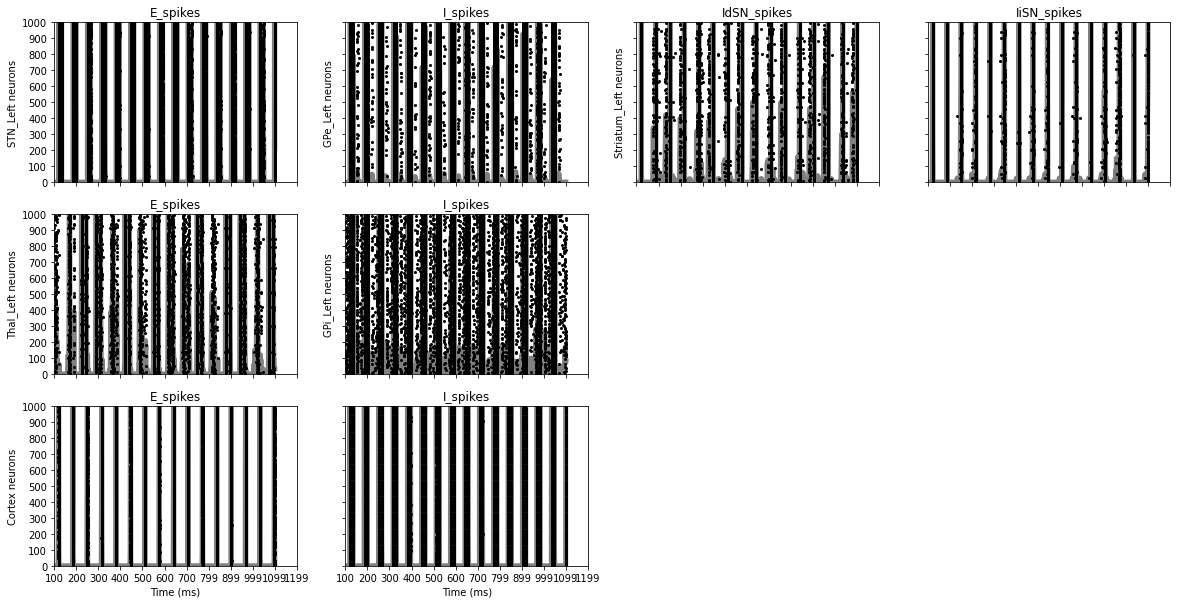

<Figure size 432x288 with 0 Axes>

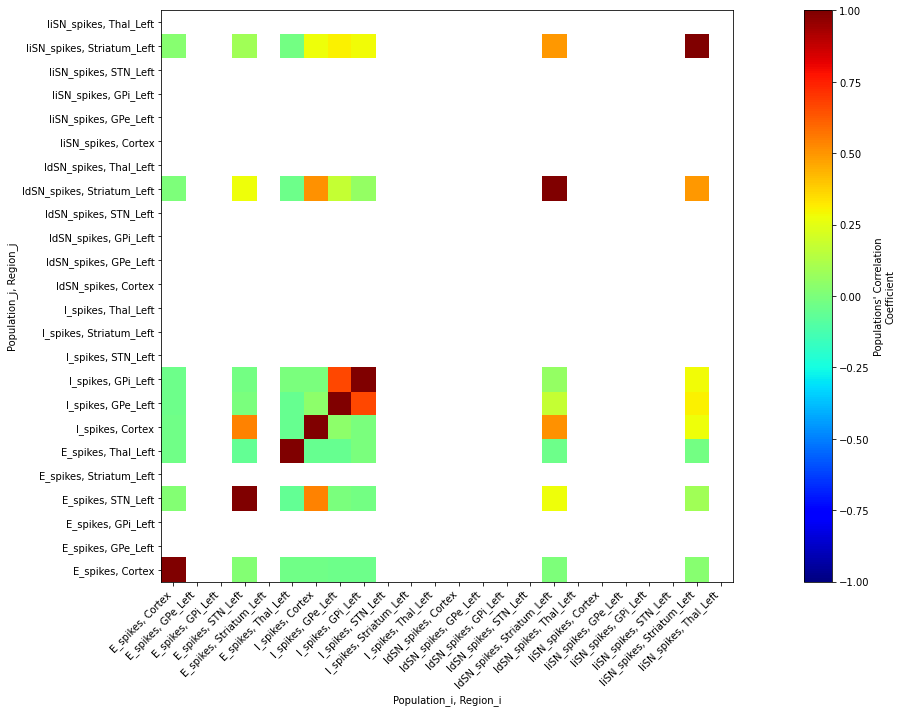

In [13]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.plot_spike_events(spikes_res["spikes"], rates=spikes_res["mean_rate_time_series"], 
                                  figsize=FIGSIZE) #
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [14]:
print("Mean spike rates:")
for pop in spikes_res["mean_rate"].coords["Population"]:
    for reg in spikes_res["mean_rate"].coords["Region"]:
        if not np.isnan(spikes_res["mean_rate"].loc[pop, reg]):
            print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                   spikes_res["mean_rate"].loc[pop, reg].values.item()))


Mean spike rates:
E - Cortex: 16.0016
E - STN_Left: 30.9481
E - Thal_Left: 25.5976
I - Cortex: 31.0031
I - GPe_Left: 32.4782
I - GPi_Left: 37.2887
IdSN - Striatum_Left: 21.1671
IiSN - Striatum_Left: 16.1066


In [15]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                              spikes_res["mean_rate_time_series"]._data,
                               connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

2021-02-26 11:15:04,073 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/basal_ganglia/outputs/Izhikevich/SpikingCortex/res/Spikes.h5
2021-02-26 11:15:04,073 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/basal_ganglia/outputs/Izhikevich/SpikingCortex/res/Spikes.h5
2021-02-26 11:15:04,103 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/E_spikes/STN_Left" (2 members)> dataset <class 'numpy.ndarray'> senders:
[484 479 593 ... 493 588 408] !

2021-02-26 11:15:04,103 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/E_spikes/STN_Left" (2 members)> dataset <class 'numpy.ndarray'> senders:
[484 479 593 ... 493 588 408] !

2021-02-26 11:15:04,113 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/E_spikes/STN_Left" (2 members)>

2021-02-26 11:15:04,295 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/basal_ganglia/outputs/Izhikevich/SpikingCortex/res/Mean Populations' Spikes' Rates.h5
2021-02-26 11:15:04,310 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-02-26 11:15:04,310 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-02-26 11:15:04,313 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-02-26 11:15:04,313 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-02-26 11:15:04,317 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Mean Populations' Spikes' Rates.h5" (mode r+)> dataset <class 'numpy.ndarray'> dims:
['Popula

2021-02-26 11:15:04,587 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Populations' Correlation Coefficient.h5" (mode r+)> dataset <class 'numpy.ndarray'> data:
[[[[ 1.00000000e+00             nan             nan  2.25890542e-02
                nan -3.12285576e-02]
   [            nan             nan             nan             nan
                nan             nan]
   [            nan             nan             nan             nan
                nan             nan]
   [ 2.25890542e-02             nan             nan  1.00000000e+00
                nan -5.75093978e-02]
   [            nan             nan             nan             nan
                nan             nan]
   [-3.12285576e-02             nan             nan -5.75093978e-02
                nan  1.00000000e+00]]

  [[-2.62109561e-02 -3.32763819e-02 -3.14329953e-02             nan
                nan             nan]
   [            nan             nan             nan             nan
  

2021-02-26 11:15:04,594 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-02-26 11:15:04,594 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-02-26 11:15:04,598 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-02-26 11:15:04,598 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-02-26 11:15:04,602 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> dims:
['Population_i'] !

2021-02-26 11:15:04,602 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> dims:
['Population_i'] !

2021-02-26 11:15:04,605 - WARNING - tvb_multisca

### Get  SpikingNetwork mean field variable time series and plot them

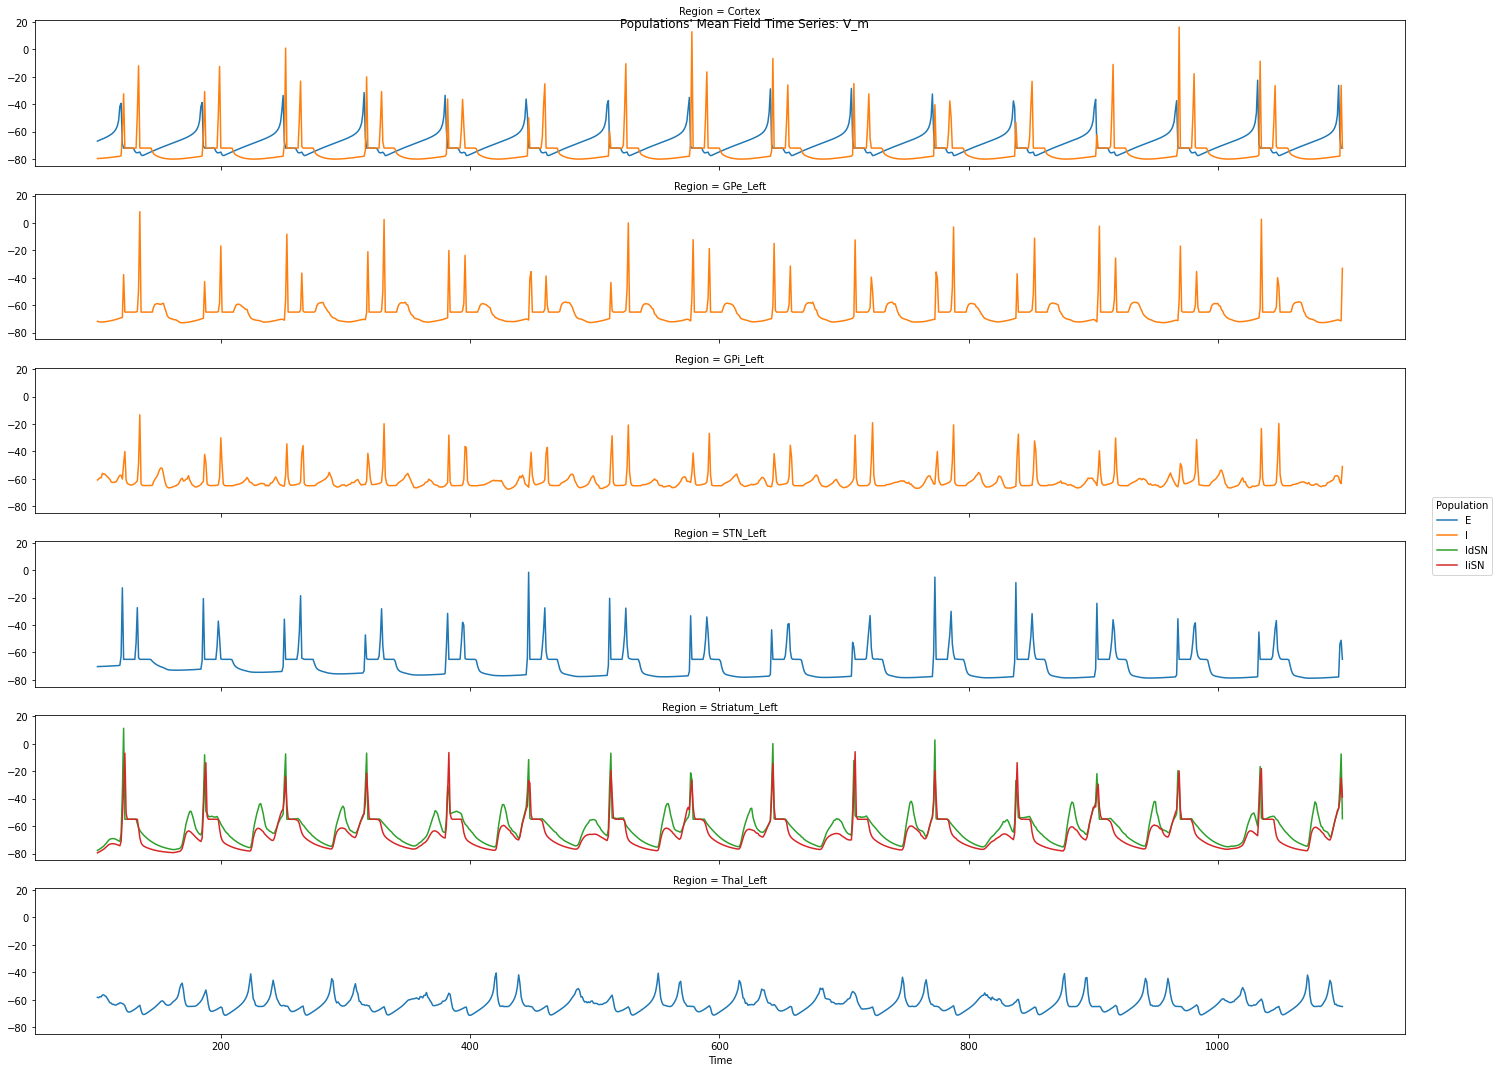

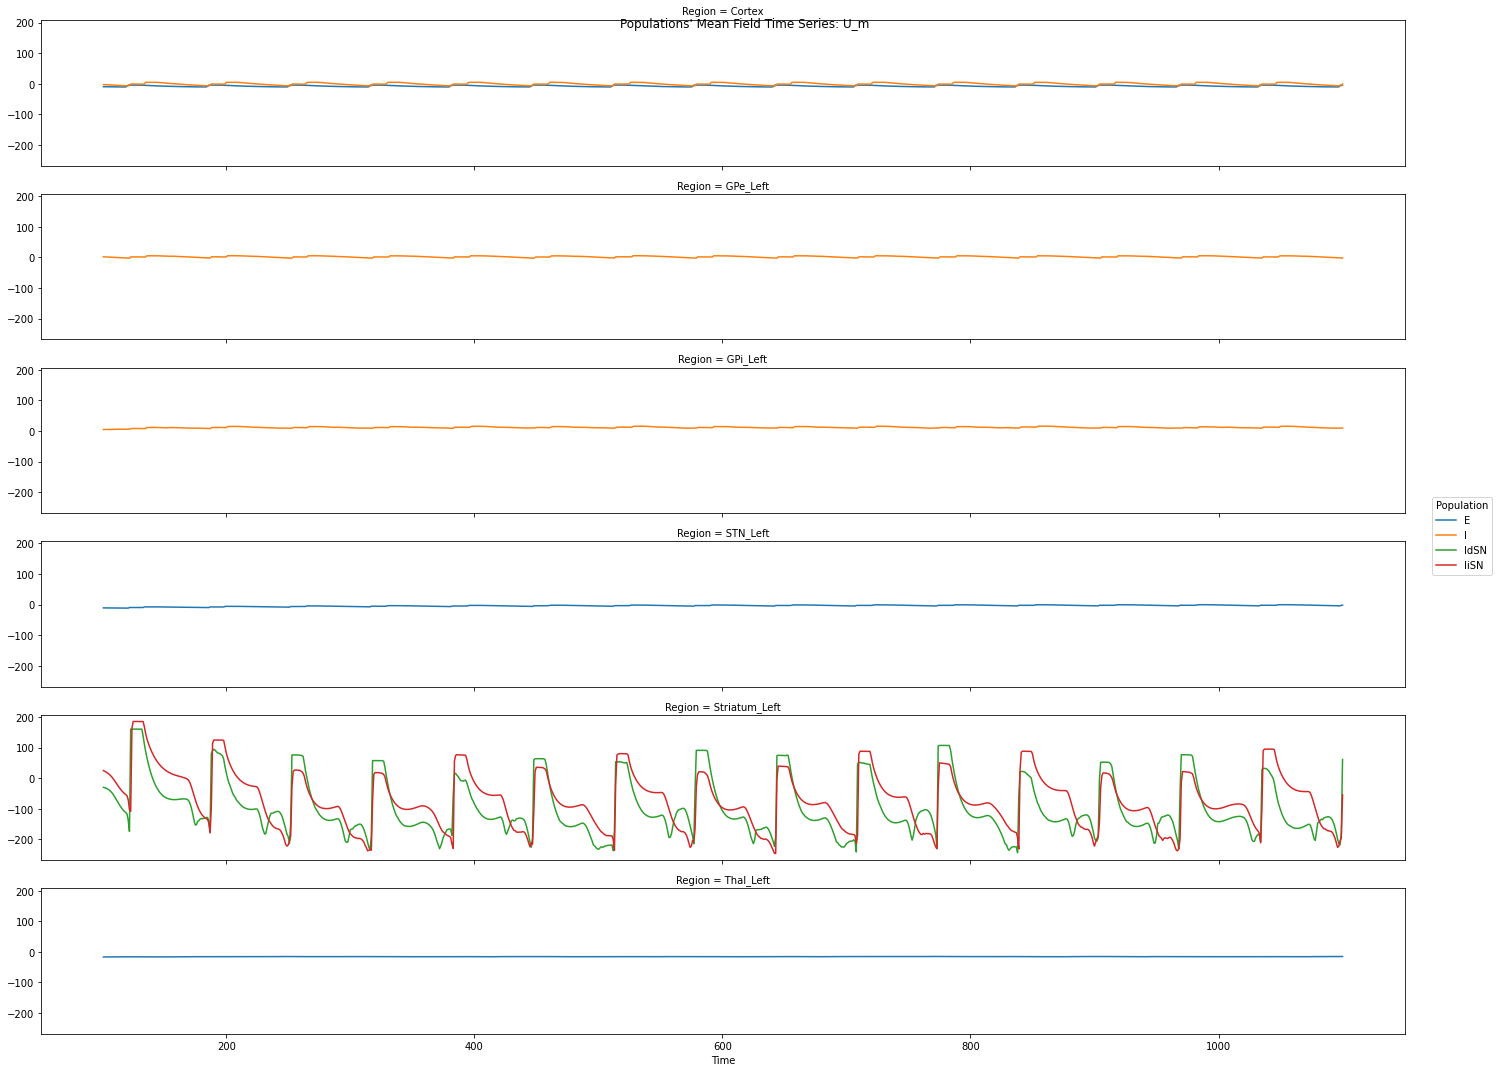

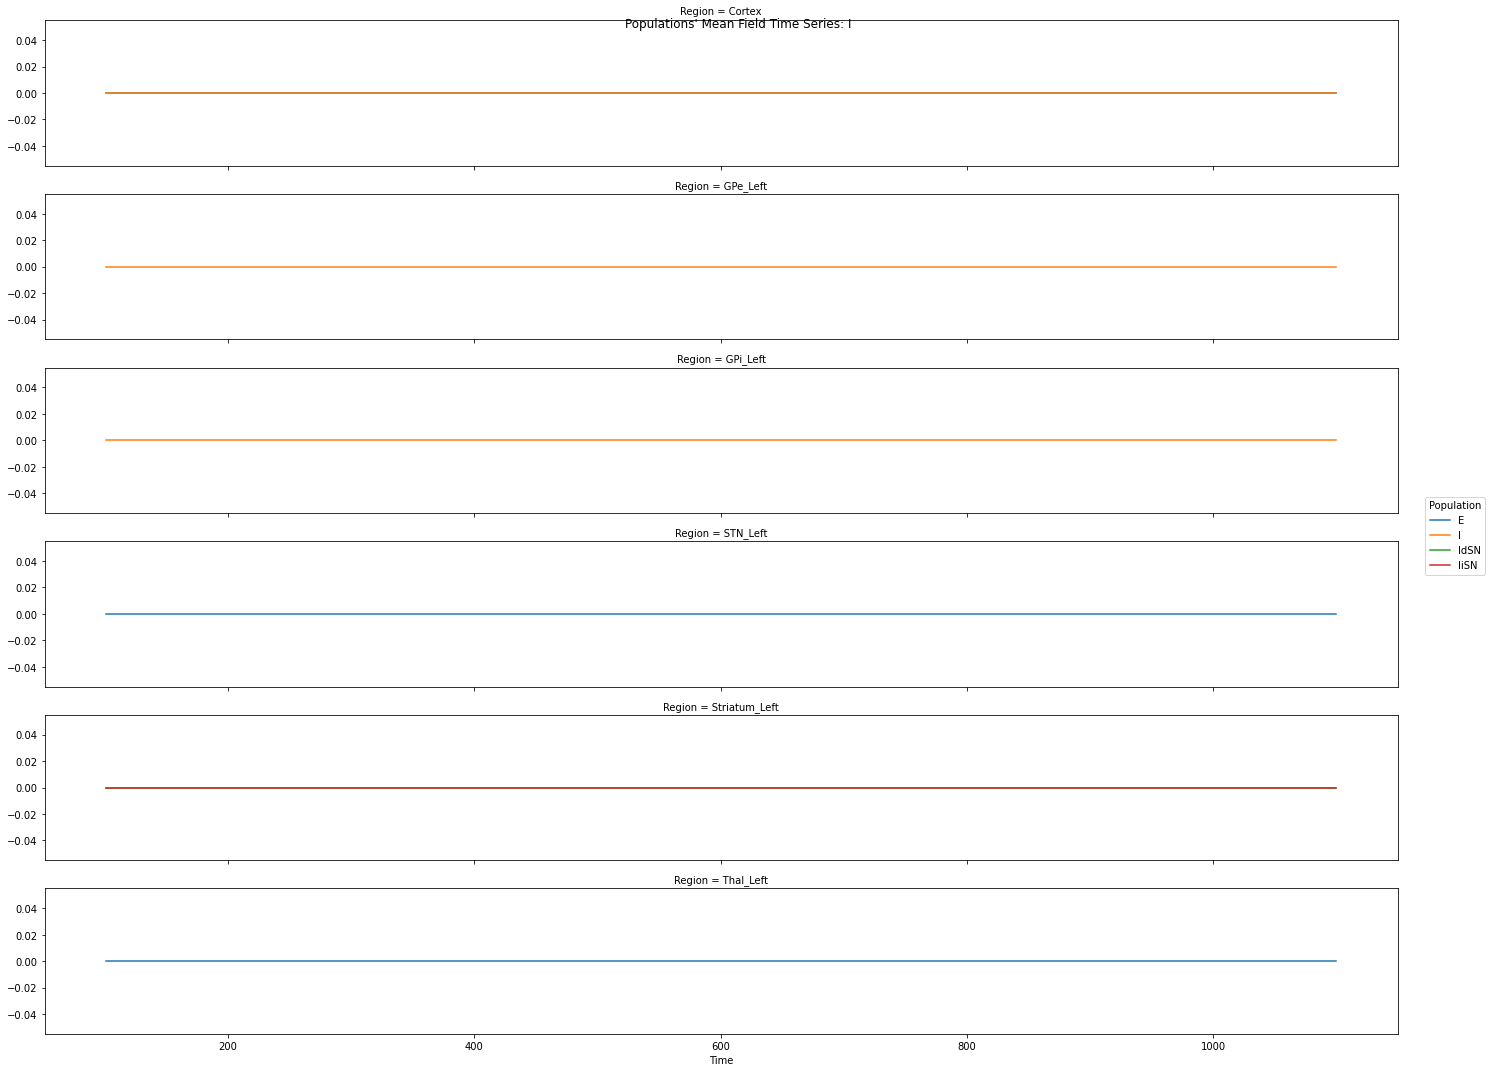

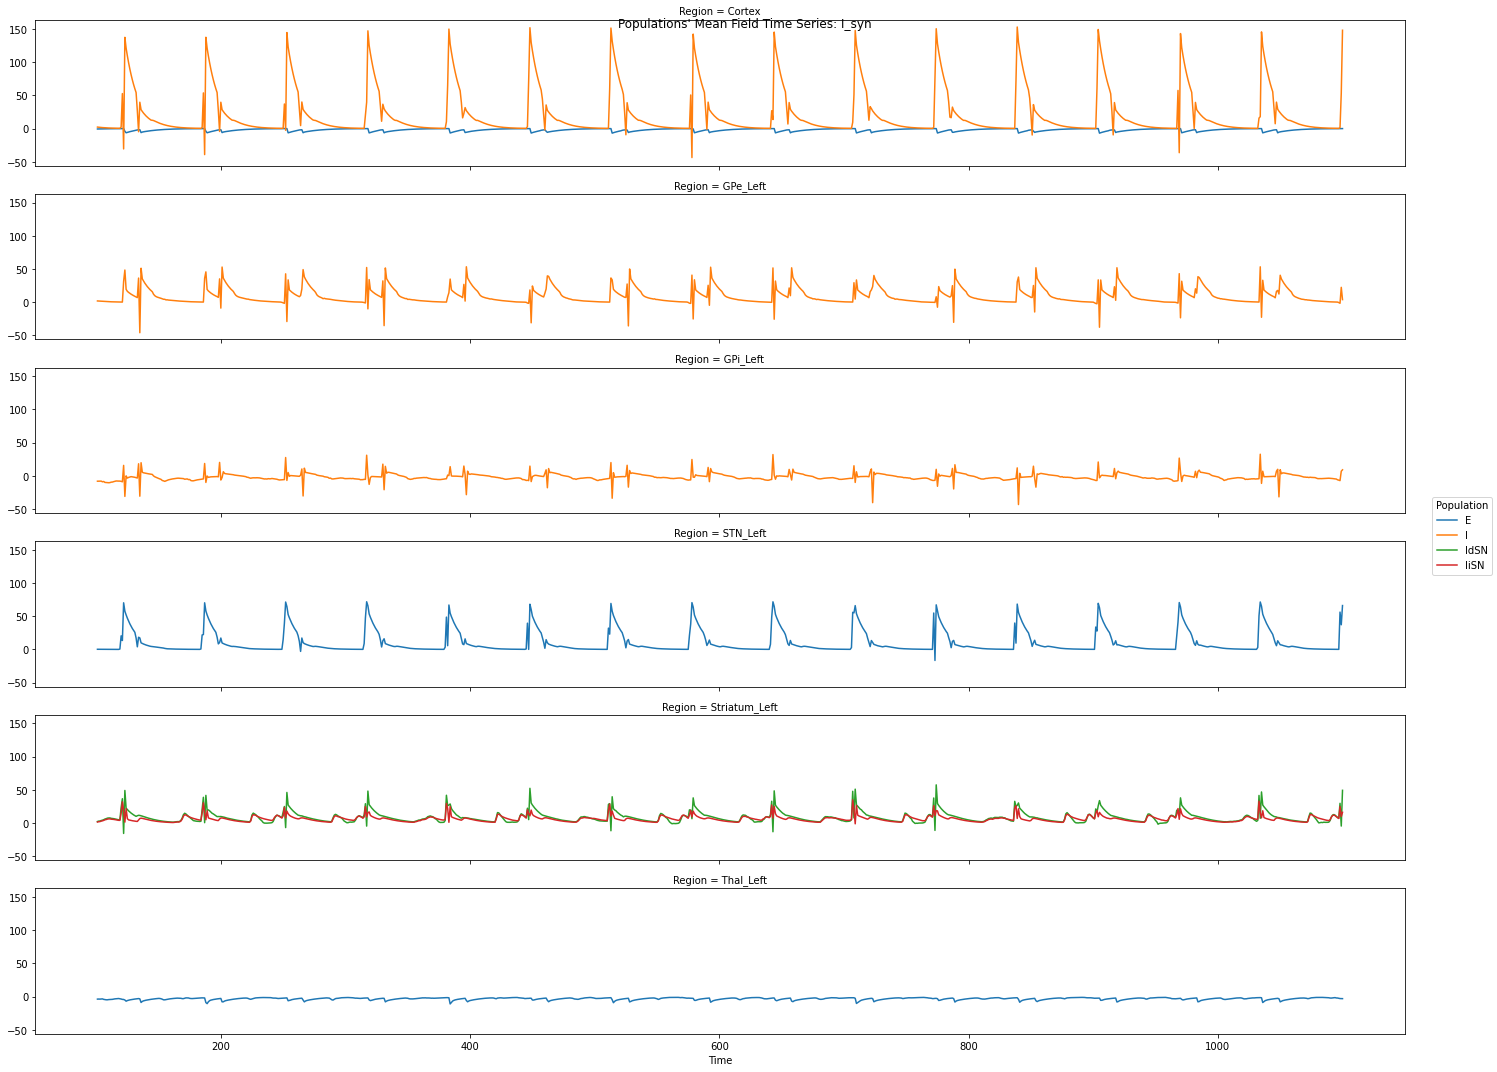

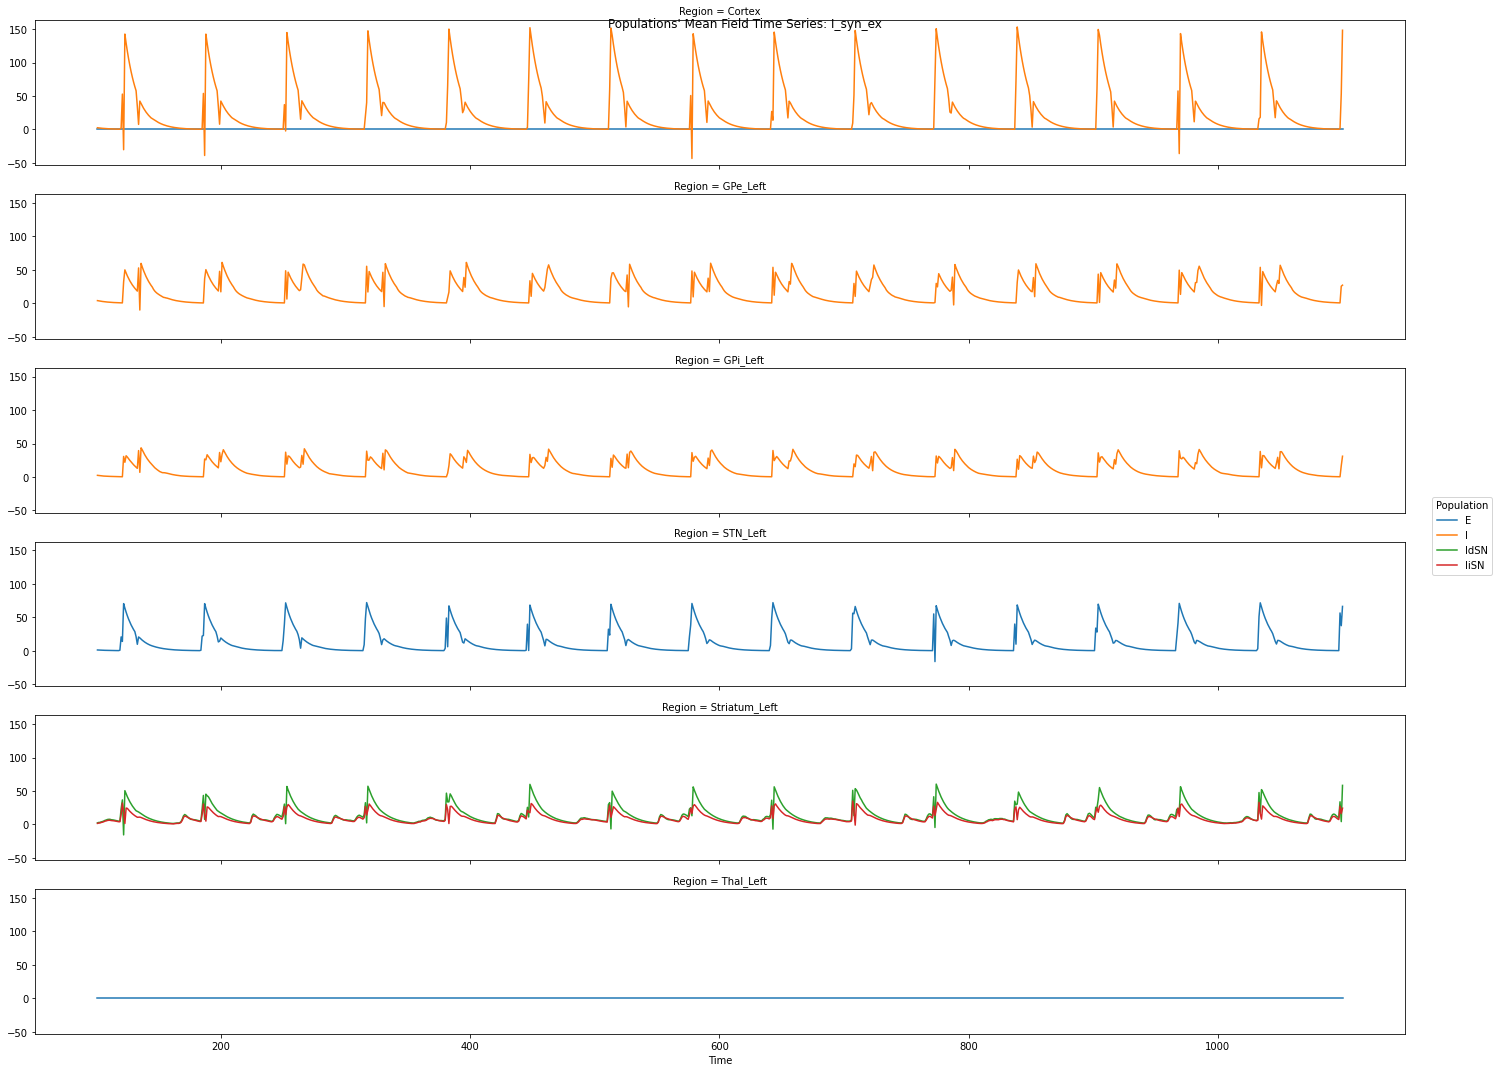

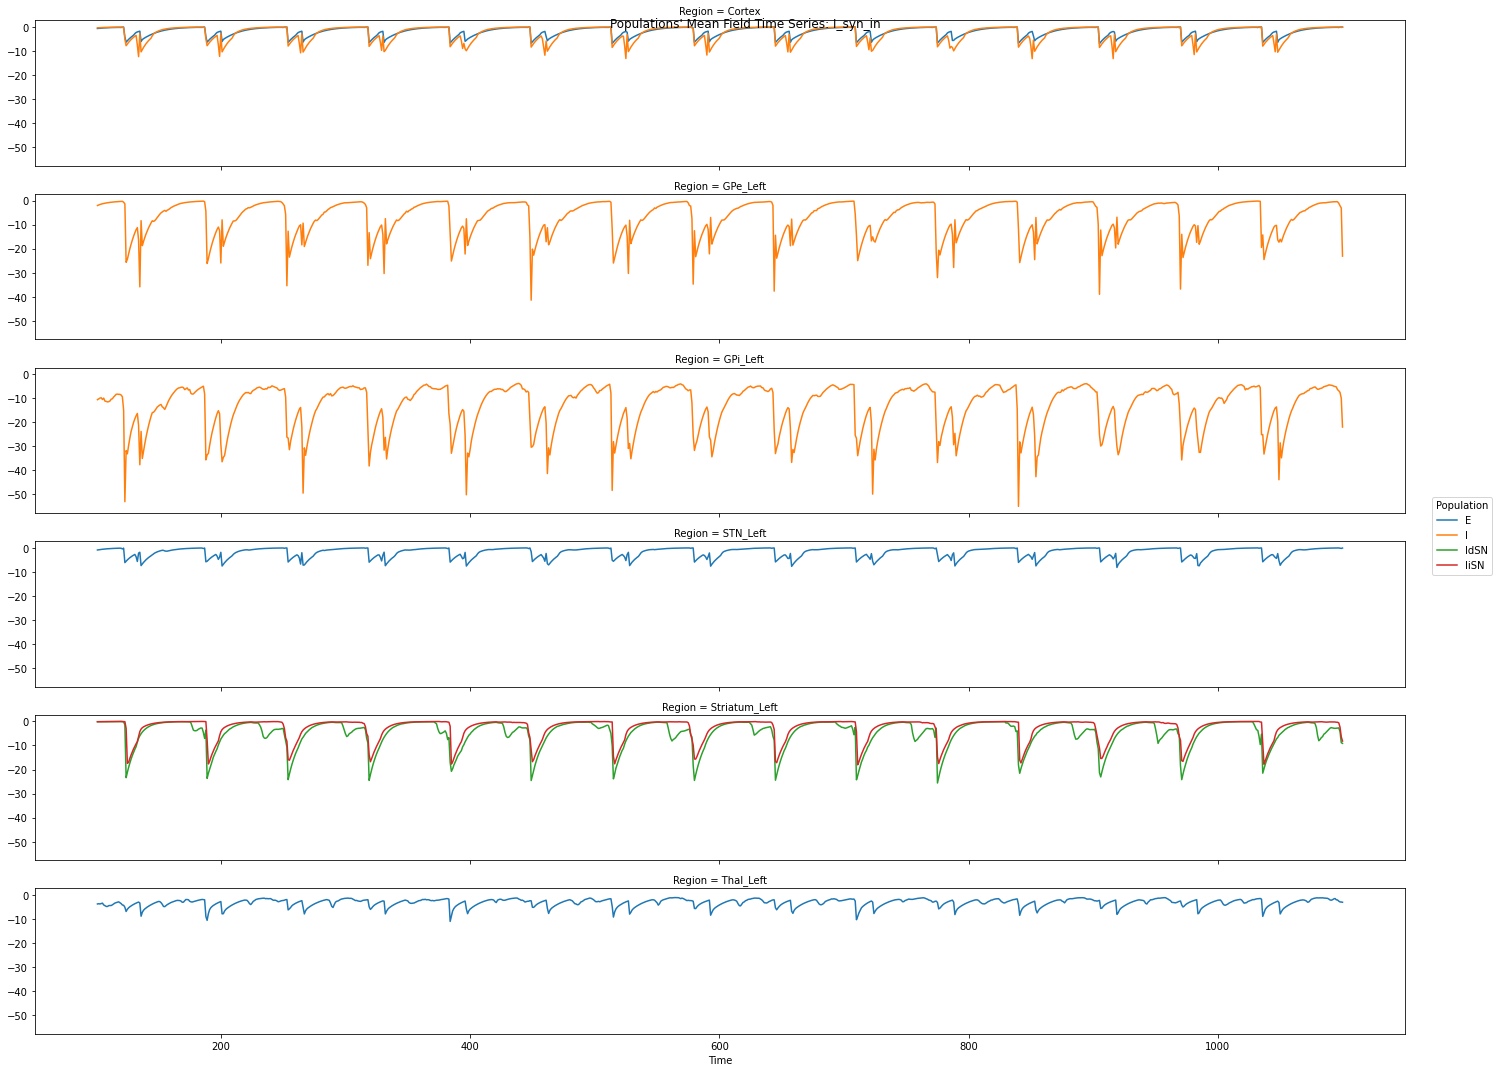

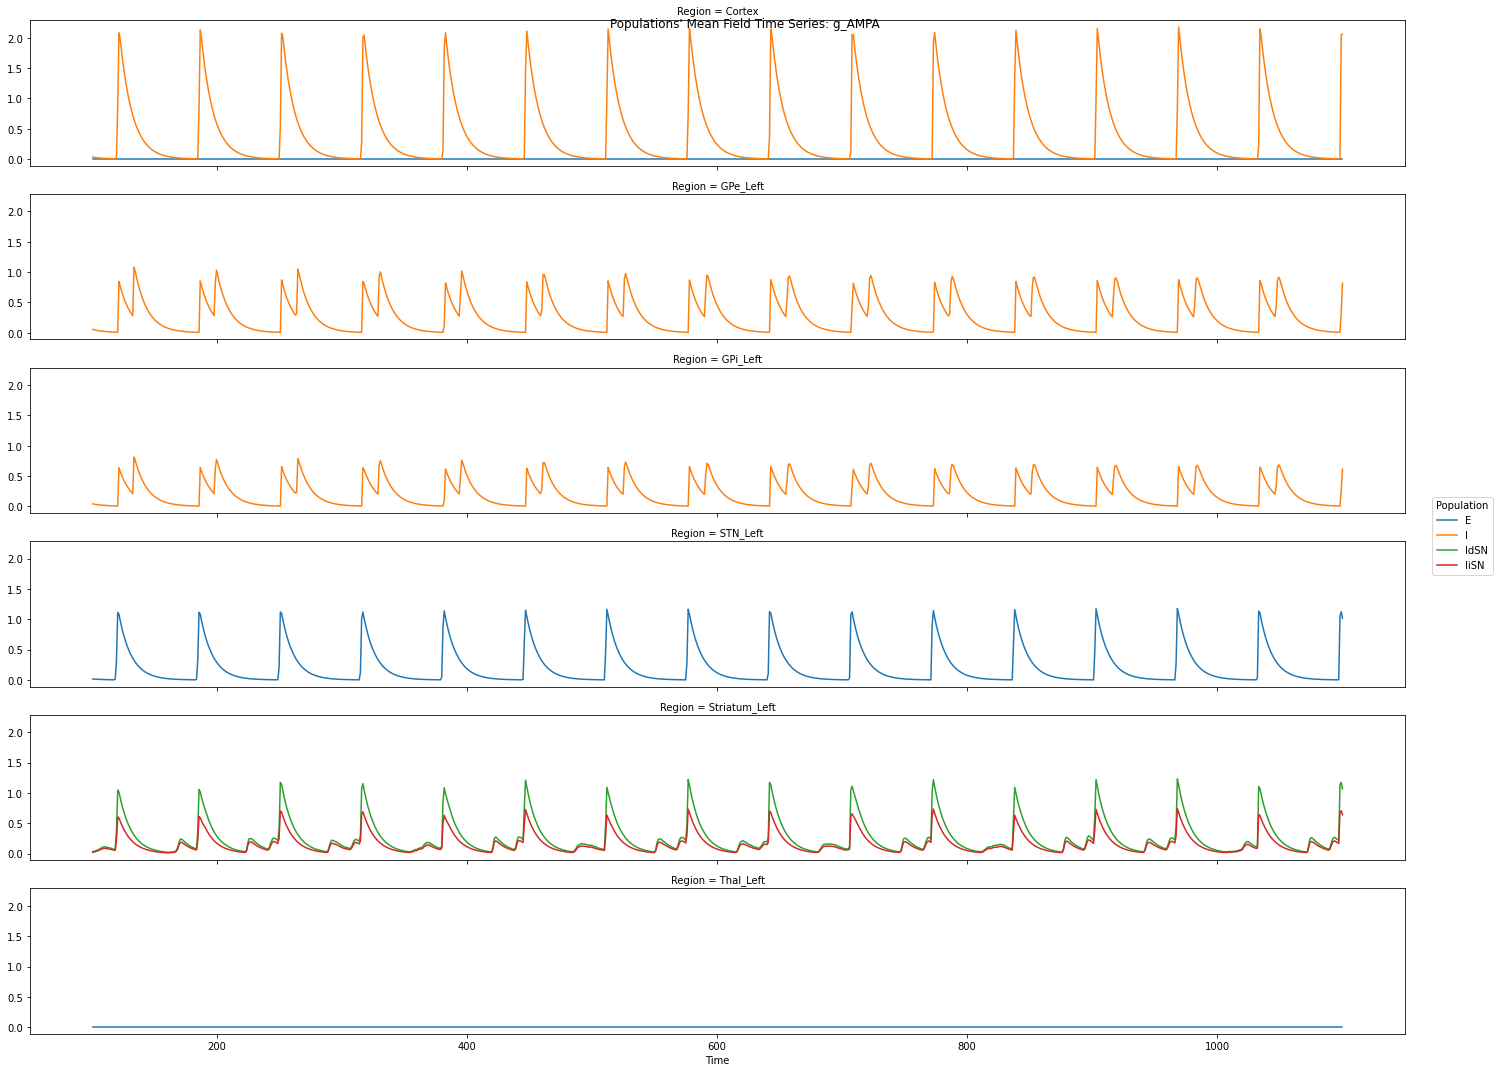

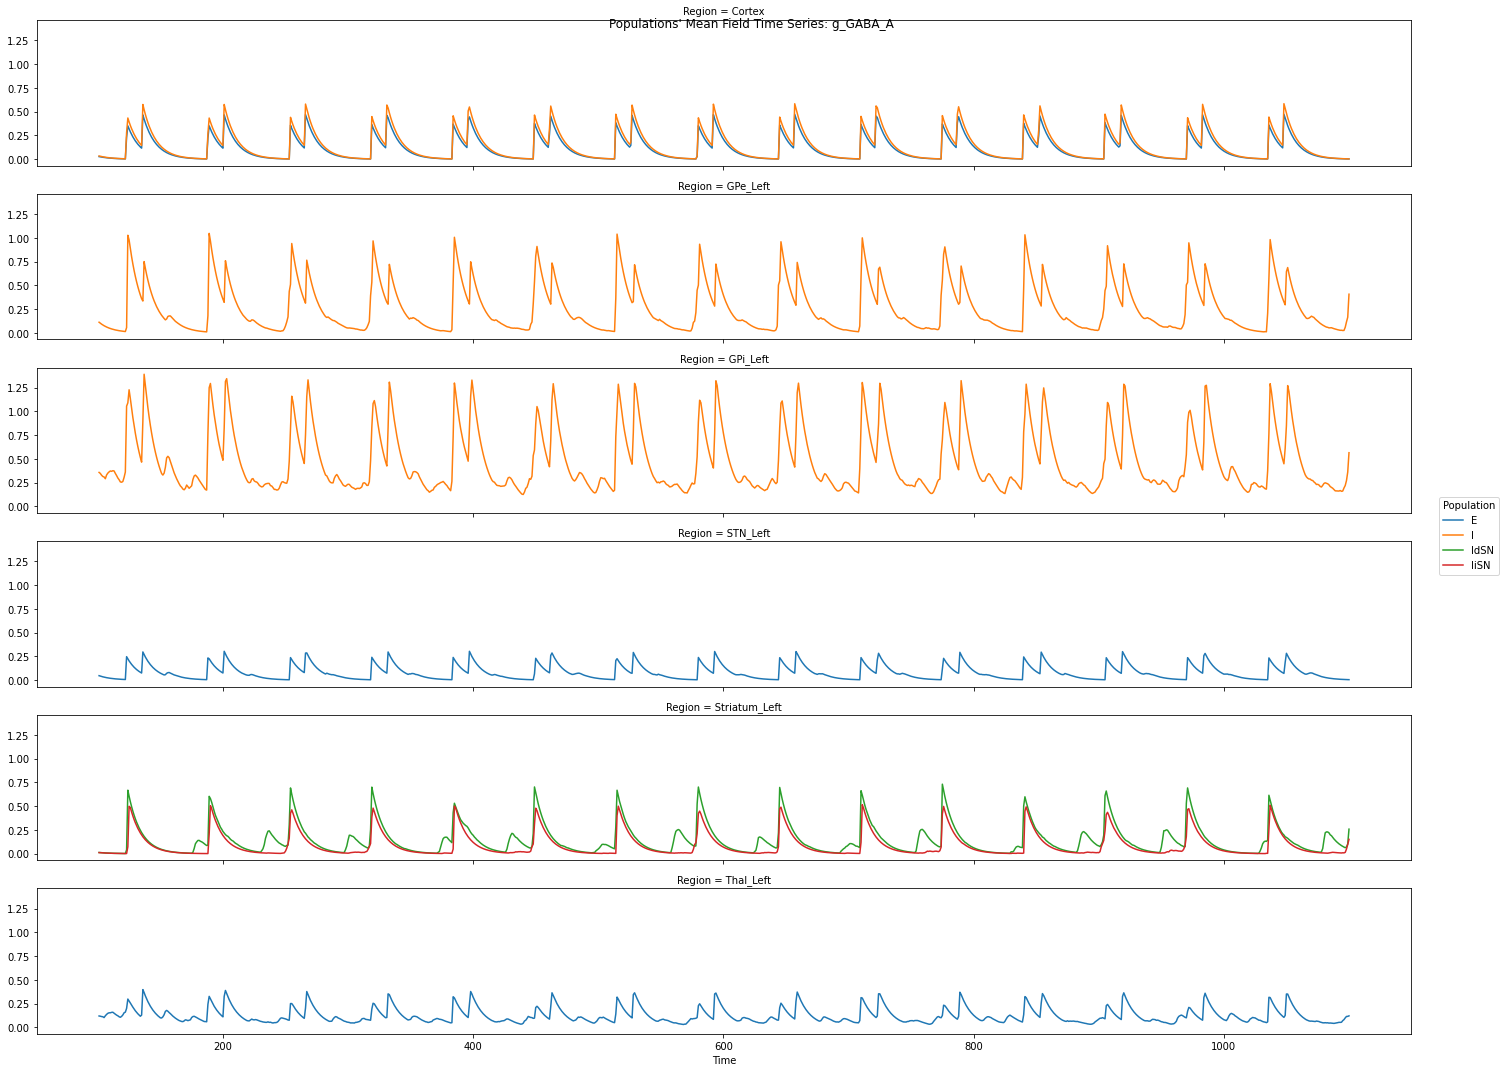

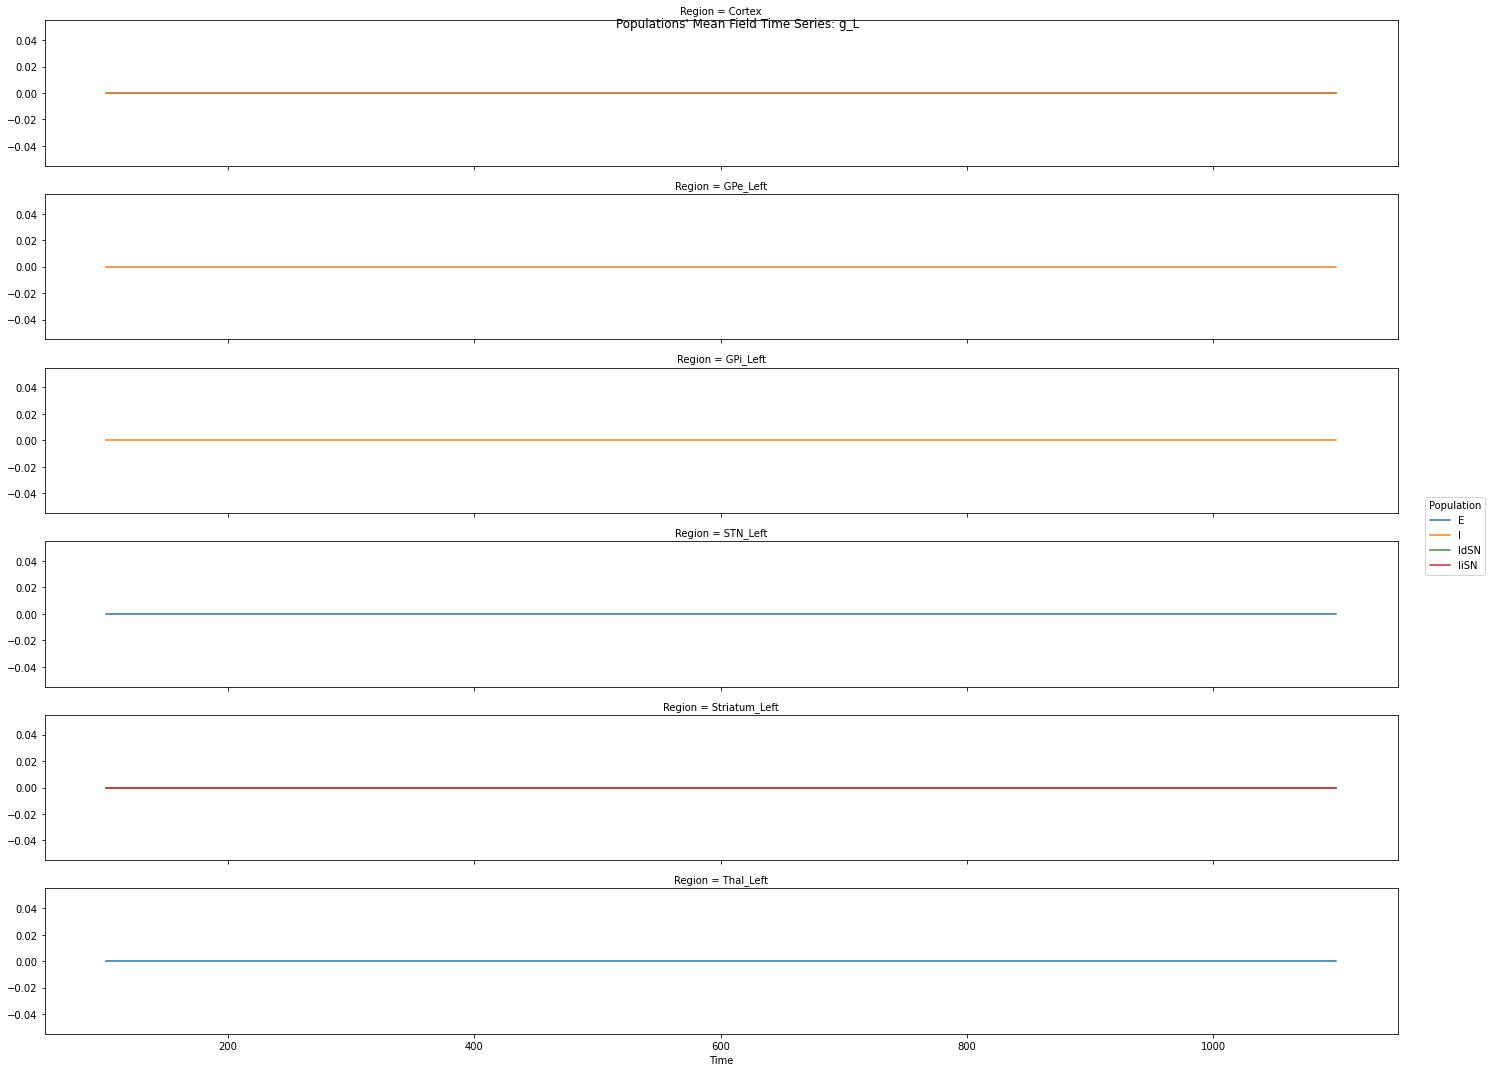

In [16]:
# Continuous time variables' data of spiking neurons
if plot_per_neuron:
    spikeNet_analyzer.return_data = True
else:
    spikeNet_analyzer.return_data = False
spikeNet_ts = \
    spikeNet_analyzer. \
         compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                 computations_kwargs={}, data_kwargs={}, return_devices=False)
if spikeNet_ts:
    if plot_per_neuron:
        mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
        spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
    else:
        mean_field_ts = spikeNet_ts
    if mean_field_ts and mean_field_ts.size > 0:
        mean_field_ts.plot_timeseries(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS)
        if mean_field_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
            mean_field_ts.plot_raster(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS,
                                      linestyle="--", alpha=0.5, linewidth=0.5)
else:
    mean_field_ts = None

In [17]:
# Write results to file:
if mean_field_ts and writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                                       mean_field_ts._data,
                                       connectivity=mean_field_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, mean_field_ts.title) + ".h5", 
                           recursive=False)

### Compute per neuron spikes' rates times series and plot them

In [18]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

In [19]:
# Regions in rows
if plot_per_neuron and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

# References

1 Sanz Leon P, Knock SA, Woodman MM, Domide L, <br>
  Mersmann J, McIntosh AR, Jirsa VK (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics 7:10. doi: 10.3389/fninf.2013.00010 <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK (2013).  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>

4 Baladron, J., Nambu, A., & Hamker, F. H. (2019). <br>
  The subthalamic nucleus‐external globus pallidus loop biases <br>
  exploratory decisions towards known alternatives: A neuro‐computational study. <br>
  European Journal of Neuroscience, 49:754–767. https://doi.org/10.1111/ejn.13666 <br>
  
5 Maith O, Villagrasa Escudero F, Ülo Dinkelbach H, Baladron J, <br>
  Horn, A, Irmen F, Kühn AA, Hamker FH (2020).<br>
  A computational model‐based analysis of basal ganglia pathway changes <br>
  in Parkinson’s disease inferred from resting‐state fMRI <br>
  European Journal of Neuroscience, 00:1–18. https://doi.org/10.1111/ejn.14868
  